In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from numpy import where
import seaborn as sns
import pickle

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler as ros
from imblearn.under_sampling import RandomUnderSampler as rus
from imblearn.over_sampling import SMOTE
# We need to do some imports from scikit learn again 
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
cols = ['Loan Identifier', 'Monthly Reporting Period', 'Origination Date', 'Maturity Date']
df = pd.read_csv('../CSV_Files//Final_Clean_Data.csv', index_col=0).drop(cols, axis=1)

In [3]:
df.head()

,Current Interest Rate,Original UPB,Original Loan Term,Loan Age,Original Loan to Value Ratio (LTV),Number of Borrowers,Debt-To-Income (DTI),First Time Home Buyer Indicator,Modification Flag,Home Ready Program Indicator,High Balance Loan Indicator,Minimum Credit Score,Foreclosed
0,3.750,65000,360,59,74,1,31,0,0,0,0,814,0
1,4.000,153000,360,58,95,2,17,0,0,0,0,788,0
2,3.625,114000,360,54,95,2,37,1,0,0,0,745,0
3,3.875,150000,360,56,70,2,16,0,0,0,0,810,0
4,4.250,40000,360,59,24,2,36,0,0,0,0,755,0


In [4]:
# # define dataset
X = df[['Current Interest Rate', 'Original UPB', 'Original Loan Term',
       'Loan Age', 'Original Loan to Value Ratio (LTV)', 'Number of Borrowers',
       'Debt-To-Income (DTI)', 'First Time Home Buyer Indicator',
       'Modification Flag', 'Home Ready Program Indicator',
       'High Balance Loan Indicator', 'Minimum Credit Score']
]

y = df['Foreclosed']

In [5]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 8255841, 1: 22816})


In [6]:
X_array = df[['Current Interest Rate', 'Original UPB', 'Original Loan Term',
       'Loan Age', 'Original Loan to Value Ratio (LTV)', 'Number of Borrowers',
       'Debt-To-Income (DTI)', 'First Time Home Buyer Indicator',
       'Modification Flag', 'Home Ready Program Indicator',
       'High Balance Loan Indicator', 'Minimum Credit Score']].to_numpy()

y_array = df['Foreclosed'].to_numpy()

Counter({0: 8255841, 1: 22816})


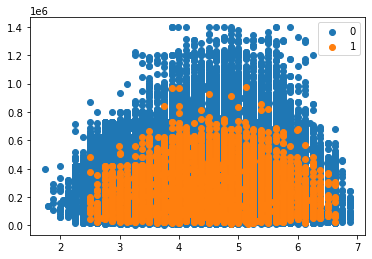

In [9]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from numpy import where

# summarize class distribution
counter = Counter(y_array)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_array == label)[0]
    plt.scatter(X_array[row_ix, 0], X_array[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [6]:
# example of random oversampling to balance the class distribution
# Combining Random Oversampling and Undersampling

# summarize class distribution
print(Counter(y))

# define undersampling strategy
under = rus(sampling_strategy=0.5)
# fit and apply the transform
X_under, y_under = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y_under))

# define oversampling strategy
over = SMOTE(sampling_strategy=0.7)
# fit and apply the transform
X_over, y_over = over.fit_resample(X_under, y_under)
# summarize class distribution
print(Counter(y_over))

Counter({0: 8255841, 1: 22816})
Counter({0: 45632, 1: 22816})
Counter({0: 45632, 1: 31942})


In [7]:
#Using the train_test_split to create train and test sets.
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, random_state = 42, test_size = 0.33)

In [8]:
#Using the train_test_split to create train and test sets.
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, random_state = 42, test_size = 0.33)

In [13]:
 params = {
        'min_child_weight': [0.2, 0.5, 1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5, 6],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }

# define model
model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
# define grid
# weights = [0.2, 0.5, 1, 10, 50. 100]
# param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_over, y_over)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[13:52:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.856383 using {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 0.2, 'subsample': 1.0}
0.851563 (0.004703) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.2, 'subsample': 0.6}
0.852375 (0.004387) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.2, 'subsample': 0.8}
0.853285 (0.004525) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.2, 'subsample': 1.0}
0.851600 (0.004721) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.5, 'subsample': 0.6}
0.852598 (0.004372) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max

In [9]:
# {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 0.2, 'subsample': 1.0}

In [10]:
# fit model on training data
model_xgb_over = XGBClassifier(reg_lambda=1,
                               importance_type='gain',                 
                               colsample_bynode=1,
                               colsample_bytree= 0.7, 
                               gamma=0.1, 
                               max_depth=4, 
                               min_child_weight=0.4,
                               num_parallel_tree=1,
                              subsample=1.0)
model_xgb_over.fit(X_train_o, y_train_o)

# make predictions for test data
predictions_xgb_over = model_xgb_over.predict(X_test_o)

print(model_xgb_over)

# evaluate predictions
accuracy = accuracy_score(y_test_o, predictions_xgb_over)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[23:08:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=0.4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 77.88%


In [11]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
AUC_ROC = roc_auc_score(y_test_o, predictions_xgb_over) #<shift + tab> to learn more
#prob_test_set[:,1] will gives the probabilities for all 1 ([0.5 to 1.0]) and 0 ([0 to 0.49])

print('Area Under ROC Curve: %.3f' % AUC_ROC)

Accuracy: 77.88%
Area Under ROC Curve: 0.767


In [12]:
print('XGBoost Over Sampling')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Area Under ROC Curve: %.3f' % AUC_ROC)
print('******************************************************')
print('Classification Report:')
print(classification_report(y_test_o, predictions_xgb_over))
df_matrix=pd.DataFrame(confusion_matrix(y_test_o, predictions_xgb_over), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])

# df_matrix.style.background_gradient(cmap='Blues')
print('*******************************************************')
df_matrix.style.background_gradient(cmap='Blues')

XGBoost Over Sampling
Accuracy: 77.88%
Area Under ROC Curve: 0.767
******************************************************
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     15087
           1       0.74      0.70      0.72     10513

    accuracy                           0.78     25600
   macro avg       0.77      0.77      0.77     25600
weighted avg       0.78      0.78      0.78     25600

*******************************************************


,Predicted False,Predicted True
Actual False,12536,2551
Actual True,3113,7400


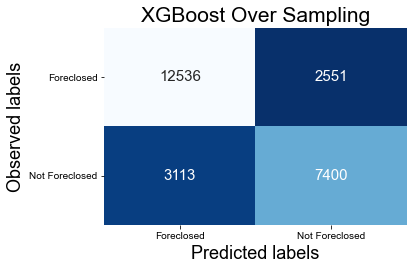

In [13]:
cm = confusion_matrix(y_test_o, predictions_xgb_over)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('XGBoost Over Sampling', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/XGBoostOverSampling')
plt.show()

In [125]:
# Computing Receiver operating characteristic (ROC)
fpr, tpr, thresholds = roc_curve(y_test_o, predictions_xgb_over)

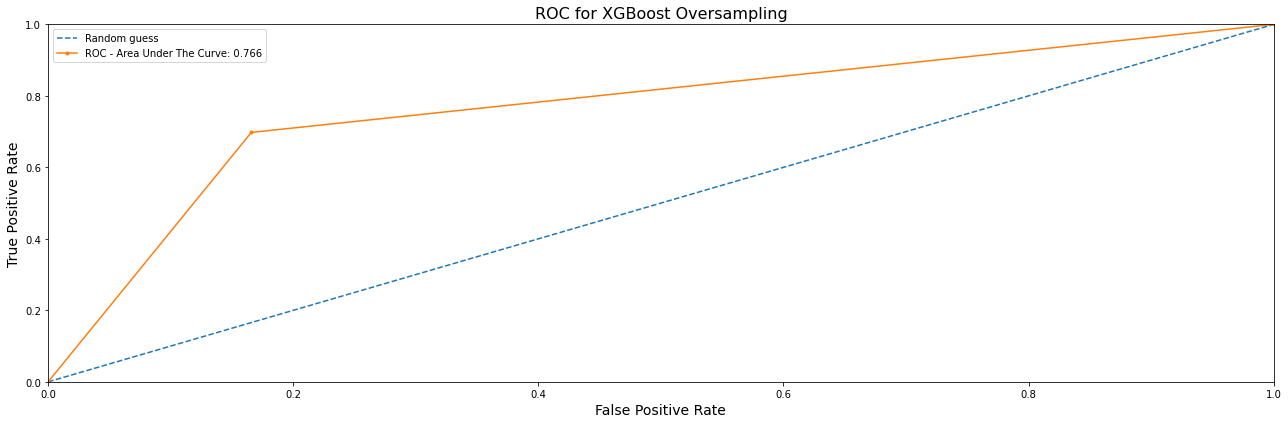

In [126]:
# Let's get the plot now!
# plot no skill - A line for random guess
plt.figure(figsize=(18,6))
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Random guess' )

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label = 'ROC - Area Under The Curve: %.3f' % AUC_ROC)

# let's set the limits (0,1)
plt.xlim([0, 1])
plt.ylim([0, 1])

# good to put title and labels
plt.title('ROC for XGBoost Oversampling', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
# putting the legends 
plt.tight_layout()
plt.legend()
plt.savefig('../Notebook_images/roc_xgboost_oversampling');

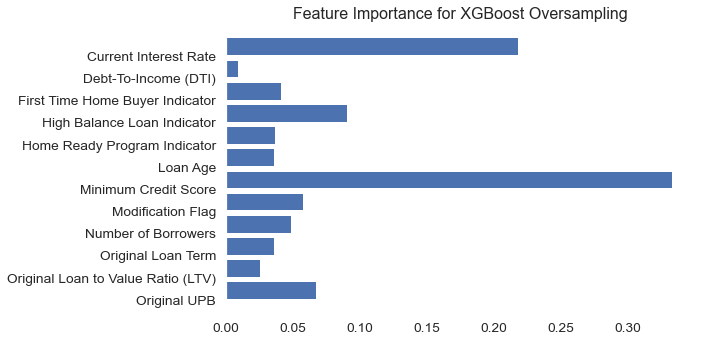

In [14]:
plt.rcParams.update({'axes.facecolor':'white'})
plt.figure(figsize=(10,5)) 
plt.barh(X_over.columns.sort_values(ascending=False), model_xgb_over.feature_importances_, align='edge')
plt.title('Feature Importance for XGBoost Oversampling', fontsize=16)
plt.tight_layout()
plt.savefig('../Notebook_images/XGBoost_feature_importance_Oversampling')
plt.show();

In [19]:
# save the model to disk
filename = '../Models/model_xgb_over.sav'
pickle.dump(model_xgb_over, open(filename, 'wb'))

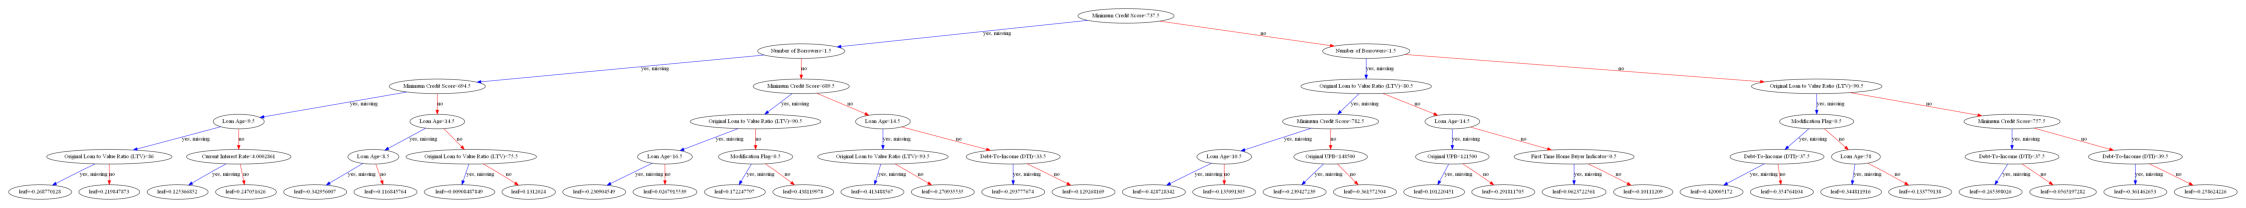

In [46]:
%matplotlib inline
from xgboost import plot_tree


plot_tree(model_xgb_over, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(40, 20)
plt.savefig("../Notebook_images/treeplot")

In [15]:
# fit model on training data
model_xgb_under = XGBClassifier(eval_metric='mlogloss',                             
                               colsample_bytree= 0.5, 
                               gamma=0.01, 
                               max_depth=4, 
                               min_child_weight=0.08,
                              subsample=1.0)
model_xgb_under.fit(X_train_u, y_train_u)

# make predictions for test data
predictions_xgb_under = model_xgb_under.predict(X_test_u)

print(model_xgb_under)

# evaluate predictions
accuracy = accuracy_score(y_test_u, predictions_xgb_under)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='mlogloss',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=0.08, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)
Accuracy: 75.81%


In [129]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
AUC_ROC = roc_auc_score(y_test_u, predictions_xgb_under) #<shift + tab> to learn more
#prob_test_set[:,1] will gives the probabilities for all 1 ([0.5 to 1.0]) and 0 ([0 to 0.49])

print('Area Under ROC Curve: %.3f' % AUC_ROC)

Accuracy: 75.53%
Area Under ROC Curve: 0.703


In [56]:
# Computing Receiver operating characteristic (ROC)
fpr, tpr, thresholds = roc_curve(y_test_u, predictions_xgb_under)

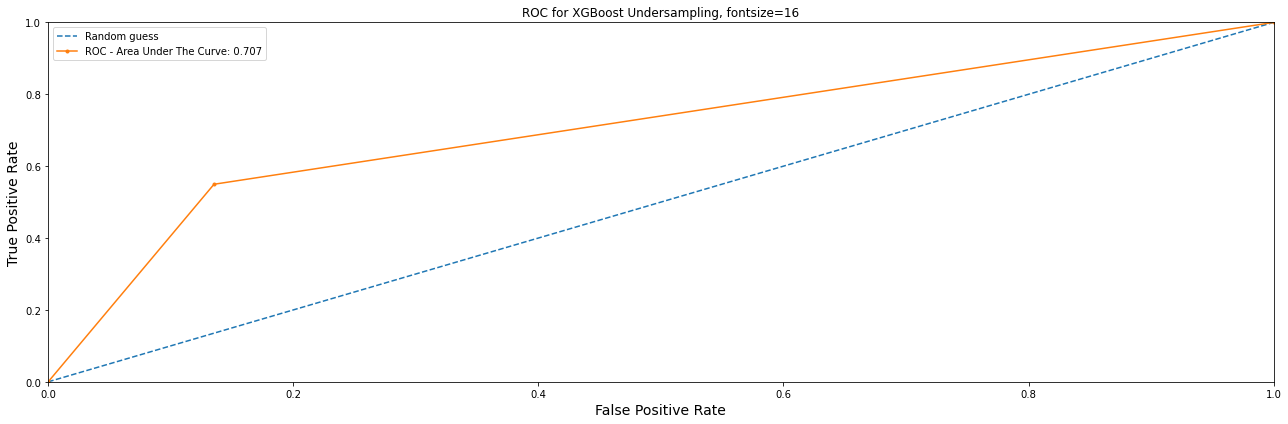

In [57]:
# Let's get the plot now!
# plot no skill - A line for random guess
plt.figure(figsize=(18,6))
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Random guess' )

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label = 'ROC - Area Under The Curve: %.3f' % AUC_ROC)

# let's set the limits (0,1)
plt.xlim([0, 1])
plt.ylim([0, 1])

# good to put title and labels
plt.title('ROC for XGBoost Undersampling, fontsize=16')
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
# putting the legends 
plt.tight_layout()
plt.legend()
plt.savefig('../Notebook_images/roc_xgboost_undersampling');

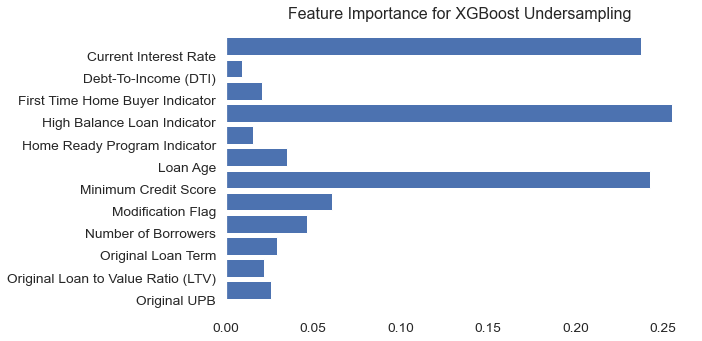

In [16]:
plt.rcParams.update({'axes.facecolor':'white'})
plt.figure(figsize=(10,5)) 
plt.barh(X_under.columns.sort_values(ascending=False), model_xgb_under.feature_importances_, align='edge')
plt.title('Feature Importance for XGBoost Undersampling', fontsize=16)
plt.tight_layout()
plt.savefig('../Notebook_images/XGBoost_feature_importance_Undersampling')
plt.show();


In [17]:
print('XGBoost Under Sampling')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Area Under ROC Curve: %.3f' % AUC_ROC)
print('******************************************************')
print('Classification Report:')
print(classification_report(y_test_u, predictions_xgb_under))
df_matrix=pd.DataFrame(confusion_matrix(y_test_u, predictions_xgb_under), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])


print('*******************************************************')
df_matrix.style.background_gradient(cmap='Blues')



XGBoost Under Sampling
Accuracy: 75.81%
Area Under ROC Curve: 0.767
******************************************************
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83     15047
           1       0.66      0.56      0.61      7541

    accuracy                           0.76     22588
   macro avg       0.73      0.71      0.72     22588
weighted avg       0.75      0.76      0.75     22588

*******************************************************


,Predicted False,Predicted True
Actual False,12924,2123
Actual True,3340,4201


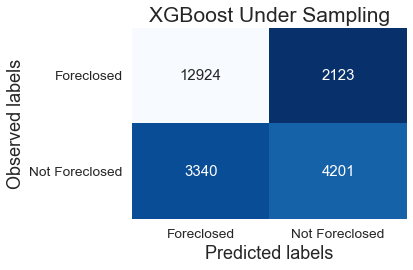

In [18]:
cm = confusion_matrix(y_test_u, predictions_xgb_under)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('XGBoost Under Sampling', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/XGBoostUnderSampling')
plt.show()